In [1]:
import matplotlib.pylab as plt
import numpy as np
import uproot

plt.style.use( "/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle")
%config InlineBackend.figure_format = 'svg'
import sys
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/")

In [2]:
from importlib import reload
import LoadMultiFiles
reload(LoadMultiFiles)
from LoadMultiFiles import LoadOneFileUprootCertainEntries,LoadOneFileUproot
use_TimeTruth = False

# dir_calib = LoadOneFileUproot("/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/myJUNOCommon/share/PSD/root_SaveTimeCharge/user_PSD_0__SN.root",
#                               name_branch="evt", return_list=False)
# dir_map = LoadOneFileUproot(f"/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/myJUNOCommon/share/tag_event/sn_tag_0_save_TimeTruth.root",
#                             name_branch='evtTruth',list_branch_filter=["HitTypeTruth", "TimeoffsetTruth"],return_list=False)

dir_calib = LoadOneFileUprootCertainEntries("/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/myJUNOCommon/share/PSD/root_SaveTimeCharge/user_PSD_0__SN.root",
                              name_branch="evt", return_list=False, n_entries_load=400)
dir_map = LoadOneFileUprootCertainEntries(f"/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/myJUNOCommon/share/tag_event/sn_tag_0_save_TimeTruth.root",
                            name_branch='evtTruth',     return_list=False, n_entries_load=400)
#
# dir_calib = LoadOneFileUprootCertainEntries("/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/myJUNOCommon/share/Sim_J21v1r0-Pre2/PSD/user_PSD_0__SN.root",
#                               name_branch="evt", return_list=False, n_entries_load=400)
# dir_map = LoadOneFileUprootCertainEntries(f"/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/myJUNOCommon/share/Sim_J21v1r0-Pre2/tag_event/sn_tag_0.root",
#                             name_branch='evtTruth',     return_list=False, n_entries_load=400)


/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/LoadMultiFiles.py:165: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dir_event[key] = np.array( list(tree[key]) )


In [3]:
print(dir_map.keys(), dir_calib.keys())
v_tags = ["pES", "eES", "AfterPulse"]
print(len(dir_map["evtID"]), len(dir_calib["Time"]))
bins = np.arange(0,5000, 6)

dict_keys(['evtID', 'nuE', 'evtType', 'recE', 'recX', 'recY', 'recZ', 'ratioSN', 'ratioDN', 'ratioAP', 'ratioDNAP', 'TriggerTime', 'TriggerTimeInterval', 'TimeTruth', 'PMTIDTruth', 'HitTypeTruth', 'TimeoffsetTruth', 'PulseTimeTruth', 'fileNo', 'detID', 'entryCalib', 'entryGen']) dict_keys(['PSDVar', 'Time', 'Charge', 'isHam', 'PMTID'])
400 400


In [4]:
# Print into PDF
from collections import Counter
from matplotlib.backends.backend_pdf import PdfPages
if use_TimeTruth:
    path_save_pdf = "/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/pdf/"
    for tag in v_tags:
        with PdfPages(f"{path_save_pdf}TimeTruth_{tag}.pdf") as pdf:
            index_tag =  (dir_map["evtType"]==tag)
            for i, (v_time, v_hitType) in enumerate (zip( dir_map["TimeTruth"][index_tag], dir_map["HitTypeTruth"][index_tag] ) ):
                plt.figure()
                for hitType in set(v_hitType):
                    plt.hist( v_time[v_hitType==hitType], bins=bins , histtype="step", label=hitType)
                # print( Counter(v_hitType) )
                plt.legend()
                plt.title(tag)
                pdf.savefig()
                plt.close()

                if i>30:
                    break


In [5]:
import pandas as pd
print(dir_calib.keys())
print( len(dir_map["evtType"]), len(dir_calib["Time"]) )
dir_concat =  dict(dir_map, **dir_calib)
print(dir_concat.keys())

# for i in range(len( dir_concat["TimeTruth"] )):
#     dir_concat["TimeTruth"][i] = dir_concat["TimeTruth"][i]-min(dir_concat["TimeTruth"][i])


v_TotalCharge = []
for v_charge in dir_concat["Charge"]:
    v_TotalCharge.append( sum(v_charge) )
dir_concat["TotalCharge"] = np.array( v_TotalCharge )

df_concat = pd.DataFrame.from_dict(dir_concat)
df_concat = df_concat[(df_concat["TotalCharge"]>0) & (df_concat["TotalCharge"]<6000) & ( (df_concat["evtType"]=="AfterPulse") |
                                                           (df_concat["evtType"]=="pES") |
                                                           (df_concat["evtType"]=="eES") ) ]

df_concat

dict_keys(['PSDVar', 'Time', 'Charge', 'isHam', 'PMTID'])
400 400
dict_keys(['evtID', 'nuE', 'evtType', 'recE', 'recX', 'recY', 'recZ', 'ratioSN', 'ratioDN', 'ratioAP', 'ratioDNAP', 'TriggerTime', 'TriggerTimeInterval', 'TimeTruth', 'PMTIDTruth', 'HitTypeTruth', 'TimeoffsetTruth', 'PulseTimeTruth', 'fileNo', 'detID', 'entryCalib', 'entryGen', 'PSDVar', 'Time', 'Charge', 'isHam', 'PMTID'])


,evtID,nuE,evtType,recE,recX,recY,recZ,ratioSN,ratioDN,ratioAP,...,fileNo,detID,entryCalib,entryGen,PSDVar,Time,Charge,isHam,PMTID,TotalCharge
0,0,19.983615,pES,0.212583,-4925.322266,-2619.566650,3983.017334,0.319780,0.671429,0.003297,...,0,6,0,6,100.0,"[838.17195, 201.4519, 1189.48395, 123.44095, 1...","[1.0997325145025394, 0.4393523729131495, 0.545...","[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, ...","[2, 5, 9, 27, 37, 66, 71, 72, 117, 129, 140, 1...",929.034894
2,2,72.964650,AfterPulse,0.482681,139.278885,-23.865454,568.739075,0.028527,0.382421,0.582113,...,0,7,2,7,100.0,"[248.7719, 498.44095, 1113.2459, 549.5199, 354...","[1.1198918055563154, 0.7996150599078559, 1.192...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[16, 27, 28, 30, 105, 203, 249, 264, 271, 277,...",1402.010661
3,3,0.000000,AfterPulse,0.311441,81.301765,-534.210999,12.567459,0.000000,0.280500,0.714500,...,0,-1,3,7,100.0,"[395.9509, 899.5199, 382.7279, 503.7619, 139.0...","[0.6494700783962112, 0.8078180685183759, 1.081...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[7, 30, 70, 87, 96, 140, 151, 153, 215, 220, 2...",2032.028124
9,9,28.514379,AfterPulse,0.207848,195.728729,7.538865,490.791351,0.014541,0.602908,0.371365,...,0,18,9,18,100.0,"[1061.3629, 991.87295, 962.5109, 99.8469, 595....","[0.8143006906004104, 0.8551261012767245, 1.008...","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 42, 58, 65, 87, 128, 147, 229, 252, 291, 3...",968.238101
15,15,89.826569,AfterPulse,0.530087,-74.632286,-138.026123,1152.315552,0.022541,0.342896,0.627732,...,0,25,15,25,100.0,"[1028.97895, 220.4809, 175.34495, 245.30595, 7...","[0.9203222040652904, 3.763125775790831, 0.8331...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3, 41, 102, 112, 173, 179, 213, 222, 228, 273...",1514.248917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,384,61.106564,AfterPulse,0.474106,-4651.727539,-5463.477051,3054.170166,0.024812,0.416541,0.545865,...,0,358,384,358,100.0,"[125.85095, 144.2459, 951.5199, 274.6989, 74.5...","[1.269764011130438, 2.146699414198324, 1.04908...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[21, 28, 30, 46, 62, 65, 81, 87, 122, 150, 153...",1411.543359
389,389,69.088573,AfterPulse,0.305346,-15173.520508,3044.275635,-5219.353516,0.021293,0.391635,0.580228,...,0,361,389,361,100.0,"[943.9129, 1169.5719, 683.4629, 335.48195, 155...","[1.3732998603574347, 1.1881870166809871, 0.340...","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[17, 20, 115, 164, 174, 184, 190, 206, 219, 23...",1380.949308
392,392,34.594923,pES,0.407966,-10100.500977,-10834.998047,1020.257751,0.518660,0.463823,0.008378,...,0,364,392,364,100.0,"[562.7519, 549.5719, 1066.85095, 580.8319, 563...","[0.7596592932894144, 1.1873722260081183, 0.856...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...","[19, 20, 21, 56, 67, 69, 74, 84, 93, 108, 149,...",1349.127092
393,393,31.298252,pES,0.254675,-6548.573730,13647.768555,4799.261719,0.423423,0.561562,0.003003,...,0,365,393,365,100.0,"[1171.5199, 906.35295, 256.85995, 270.7619, 11...","[0.9242208887924215, 1.212580567731286, 1.3094...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[30, 67, 76, 87, 108, 145, 186, 196, 224, 227,...",1033.800339


# Study Time Profile of MC Truth

## (1) Plot Time Profile

In [6]:
from HistTools import GetBinCenter
bins = np.arange(0,5000, 6)
# bins=1000
bins_center = GetBinCenter(bins)

# v_tags = [ "AfterPulse"]
if use_TimeTruth:
    for tag in v_tags:
        plt.figure()
        for time in df_concat[df_concat["evtType"]==tag]["TimeTruth"][:5]:
            # plt.figure()
            plt.hist(time, bins=bins, histtype="step")
            plt.xlabel("Time[ns]")
        plt.title(tag)

# nPMTs Trigger Study
## (1) Calib Data
### Check Trigger Condition

['pES', 'eES', 'AfterPulse']


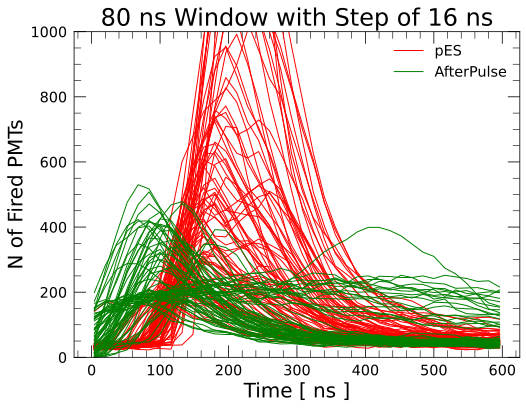

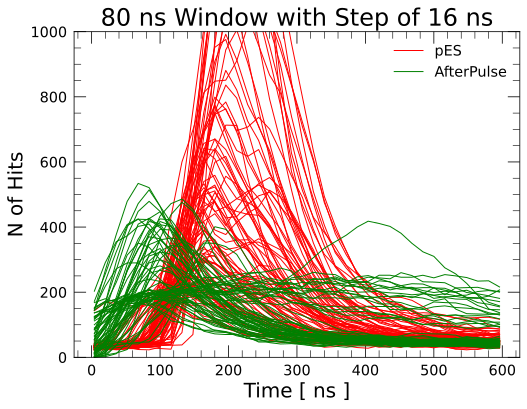

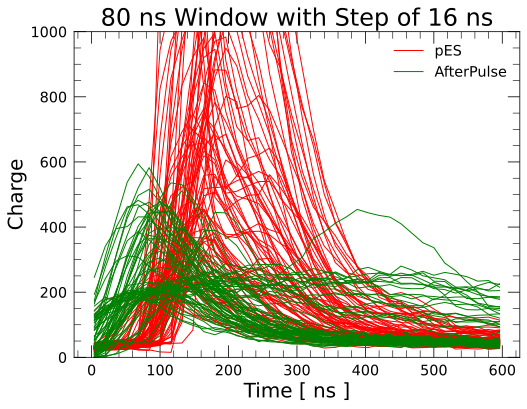

In [14]:
from TriggerTools import GetHitsCount
from PlotTools import LegendNotRepeated
from PmtIDMap import  PMTIDMap
pmt_map = PMTIDMap("/cvmfs/juno.ihep.ac.cn/centos7_amd64_gcc830/Pre-Release/J21v1r0-Pre2/data/Simulation/ElecSim/PmtData_Lpmt.root")
subtractTOF = True

win_width = 80
# win_width = 300
step_slide = 16

v_time_lowerLimit = np.arange(4, 600, step_slide)
v_time_upperLimit = v_time_lowerLimit+win_width
time_center = ( v_time_lowerLimit + v_time_upperLimit ) /2

v_strategy = ["nPMT_w/o_repeat", "nPMT_w/_repeat", "Charge"]
v_colors = ["r", "b", "g"]
v_ls = ["-", "--","-."]
print(v_tags)
for strategy in v_strategy:
    plt.figure(strategy)
for i, tag in enumerate (v_tags ):
    for index, row in list( df_concat[ df_concat["evtType"]==tag ].iterrows() )[:100]:
        dir_nHits = {key:[] for key in v_strategy}
        for time_lowerLimit, time_upperLimit in zip( v_time_lowerLimit, v_time_upperLimit ):
            for strategy in v_strategy:
                if not subtractTOF:
                    dir_nHits[strategy].append( GetHitsCount(row["PMTID"], row["Time"], row["Charge"],
                                     time_lowerLimit, time_upperLimit , strategy=strategy) )
                else:
                    dir_nHits[strategy].append( GetHitsCount(row["PMTID"], row["Time"], row["Charge"],
                                     time_lowerLimit, time_upperLimit , strategy=strategy) )

        for j, strategy in enumerate( v_strategy ):
            plt.figure(strategy)
            # plt.step(time_center,dir_nHits[strategy], linewidth=2, label=strategy, color=v_colors[j], ls=v_ls[i])
            plt.plot(v_time_lowerLimit,dir_nHits[strategy], linewidth=1, label=tag, color=v_colors[i])

# plt.xlim(0,400)
for strategy in v_strategy:
    plt.figure(strategy)
    plt.ylim(0,1000)
    plt.xlabel("Time [ ns ]")
    plt.title(f"{win_width} ns Window with Step of {step_slide} ns")
    LegendNotRepeated()

    if strategy == "nPMT_w/o_repeat":
        plt.ylabel("N of Fired PMTs")
    elif strategy == "nPMT_w/_repeat":
        plt.ylabel("N of Hits")
    elif strategy == "Charge":
        plt.ylabel("Charge")



### Check Trigger Window Calculation

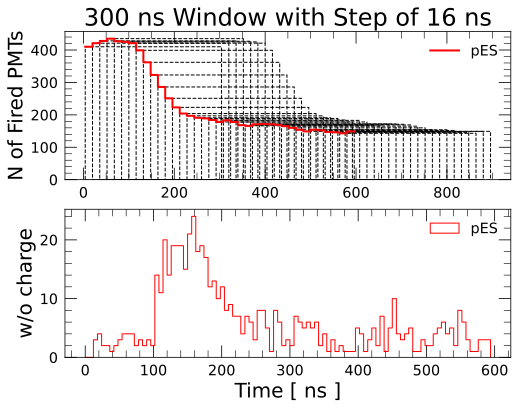

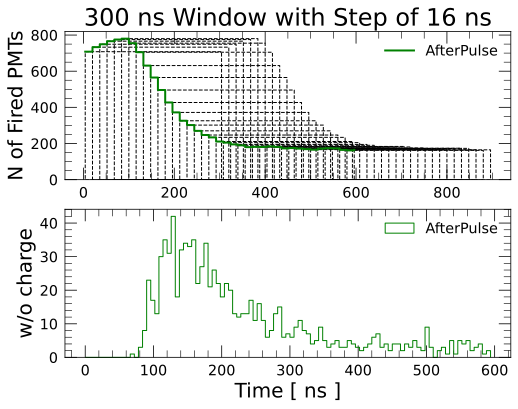

In [8]:
v_strategy = ["nPMT_w/o_repeat"]
from matplotlib.backends.backend_pdf import PdfPages
path_save_pdf = "/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/pdf/"

for i, tag in enumerate (v_tags ):
    with PdfPages(f"{path_save_pdf}nPMTFiredAndTimeProfile_{tag}.pdf") as pdf:
        for index, row in list( df_concat[ df_concat["evtType"]==tag ].iterrows() ):
            fig = plt.figure()
            dir_nHits = {key:[] for key in v_strategy}
            for time_lowerLimit, time_upperLimit in zip( v_time_lowerLimit, v_time_upperLimit ):
                for strategy in v_strategy:
                    dir_nHits[strategy].append( GetHitsCount(row["PMTID"], row["Time"], row["Charge"],
                                         time_lowerLimit, time_upperLimit , strategy=strategy) )

            for j, strategy in enumerate( v_strategy ):
                # plt.figure(strategy)
                fig.add_subplot(211)
                plt.bar(v_time_lowerLimit,dir_nHits[strategy], linewidth=1,width=win_width,align="edge", color=v_colors[i],
                        fill=False,ls="--")
                plt.step(v_time_lowerLimit,dir_nHits[strategy], linewidth=2, label=tag, color=v_colors[i],where="post")
                # plt.plot(v_time_lowerLimit,dir_nHits[strategy], linewidth=1, label=tag, color=v_colors[i])
                plt.ylabel("N of Fired PMTs")
                plt.title(f"{win_width} ns Window with Step of {step_slide} ns")
                LegendNotRepeated()

                fig.add_subplot(212)
                plt.hist(row["Time"], histtype="step", bins=np.arange(0, 600, 6),linewidth=1, label=tag, color=v_colors[i])
                plt.ylabel("w/o charge")
                plt.xlabel("Time [ ns ]")
                LegendNotRepeated()
            # pdf.savefig()
            # plt.close()
            break


## (2) Time Truth
### Check Whether Truth Align with Calib Data

[4, 10, 10, 11, 12, 13, ... 1.24e+03, 1.24e+03, 1.25e+03, 1.25e+03, 1.25e+03]
[100, 156, 94, 137, 89, 128, ... 1.23e+03, 1.23e+03, 1.24e+03, 1.24e+03, 1.25e+03]


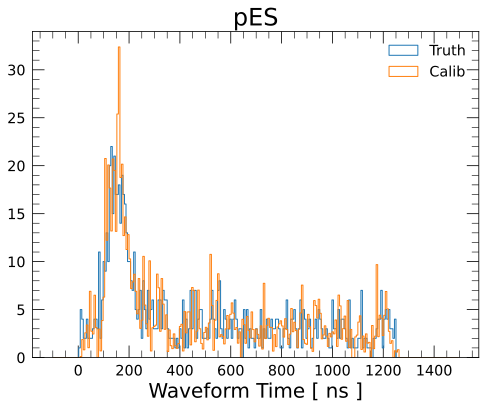

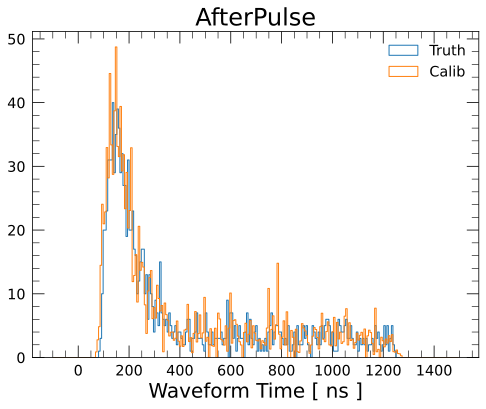

In [9]:
use_TimeTruth = True
bins_time = np.arange(-100, 1500, 6)
if use_TimeTruth:
    for tag in v_tags:
        for index, row in list( df_concat[df_concat["evtType"]==tag].iterrows() )[:5]:
            plt.figure()
            v_time_with_tag = row["PulseTimeTruth"]-row["TriggerTime"]+100
            # v_time_with_tag = row["TimeTruth"]
            v_time_calib_with_tag = row["Time"]
            v_charge_calib_with_tag = row["Charge"]
            print(v_time_with_tag)
            # delta_time = GetAlignValue(v_time_with_tag, v_time_calib_with_tag, v_charge_calib_with_tag, np.arange(0,5000, 6), align_method="threshold")
            plt.hist(v_time_with_tag
                     , bins=bins_time, histtype="step", label="Truth")

            plt.hist(v_time_calib_with_tag, bins=bins_time, histtype="step", label="Calib",weights=row["Charge"])

            plt.xlabel("Waveform Time [ ns ]")
            plt.legend()
            plt.title(tag)

            break


### Check Trigger Condition With Truth

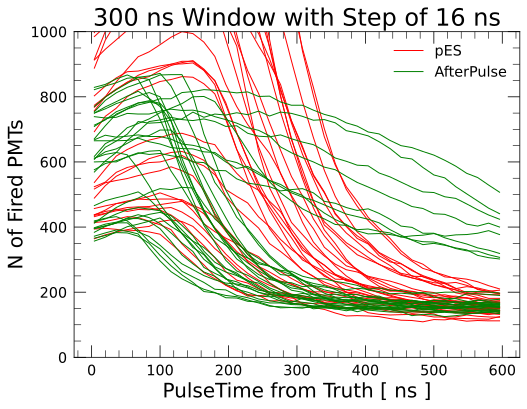

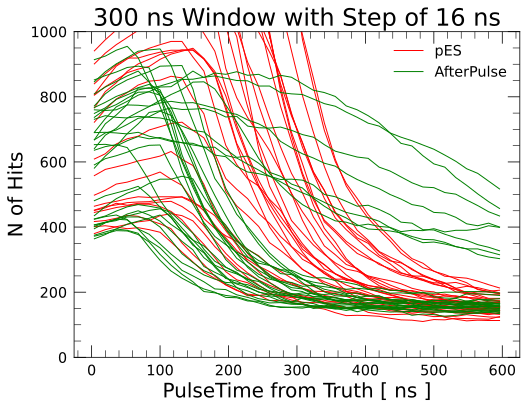

In [10]:
v_strategy = ["nPMT_w/o_repeat", "nPMT_w/_repeat"]

if use_TimeTruth:
    for strategy in v_strategy:
        plt.figure(strategy)
    for i, tag in enumerate ( v_tags ):
        for index, row in list( df_concat[ df_concat["evtType"]==tag ].iterrows() )[:30]:
            dir_nHits = {key:[] for key in v_strategy}
            for time_lowerLimit, time_upperLimit in zip( v_time_lowerLimit, v_time_upperLimit ):
                for strategy in v_strategy:
                    # index_hitType = (row["HitTypeTruth"]=="AfterPulse")
                    # dir_nHits[strategy].append( GetHitsCount(row["PMTIDTruth"][index_hitType], row["TimeTruth"][index_hitType], None,
                    v_time_with_tag = row["PulseTimeTruth"]-row["TriggerTime"]+100
                    dir_nHits[strategy].append( GetHitsCount(row["PMTIDTruth"], v_time_with_tag, None,
                                         time_lowerLimit, time_upperLimit , strategy=strategy) )

            for j, strategy in enumerate( v_strategy ):
                plt.figure(strategy)
                # plt.step(time_center,dir_nHits[strategy], linewidth=2, label=strategy, color=v_colors[j], ls=v_ls[i])
                plt.plot(v_time_lowerLimit,dir_nHits[strategy], linewidth=1, label=tag, color=v_colors[i])

    for strategy in v_strategy:
        plt.figure(strategy)
        plt.ylim(0,1000)
        plt.xlabel("PulseTime from Truth [ ns ]")
        plt.title(f"{win_width} ns Window with Step of {step_slide} ns")
        LegendNotRepeated()

        if strategy == "nPMT_w/o_repeat":
            plt.ylabel("N of Fired PMTs")
        elif strategy == "nPMT_w/_repeat":
            plt.ylabel("N of Hits")
        elif strategy == "Charge":
            plt.ylabel("Charge")

### Plot Contribution of Different Pulse Type

In [11]:
import PlotTools
reload(PlotTools)
from PlotTools import PlotContributionOfEachArray
import tqdm

strategy = "nPMT_w/o_repeat"
if use_TimeTruth:
    for i, tag in enumerate ( v_tags ):
    # for i, tag in enumerate ( ["AfterPulse"] ):
        pdf = PdfPages(f"/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/pdf/ContributionOfPulse_{tag}.pdf")
        for index, row in tqdm.tqdm( list( df_concat[ df_concat["evtType"]==tag ].iterrows() )[:20] ):
            plt.figure()
            v_hitType = set(row["HitTypeTruth"])
            v2d_NPMTs = []
            for time_lowerLimit, time_upperLimit in zip( v_time_lowerLimit, v_time_upperLimit ):
                v_time_with_tag = row["PulseTimeTruth"]-row["TriggerTime"]+100
                v_NPMTs_in_one_time_bin = []
                for PulseType in set(row["HitTypeTruth"]):
                    index_PulseType = (row["HitTypeTruth"]==PulseType)

                    v_NPMTs_in_one_time_bin.append( GetHitsCount(row["PMTIDTruth"][index_PulseType], v_time_with_tag[index_PulseType], None,
                                         time_lowerLimit, time_upperLimit , strategy=strategy) )
                v2d_NPMTs.append( v_NPMTs_in_one_time_bin )
            PlotContributionOfEachArray(v2d_NPMTs, label_index=list(v_time_lowerLimit), label_columns=list(v_hitType),show_table=False,reverse=True)
            plt.xlabel("Time [ ns ]")
            plt.ylabel("$Fired\ N_{PMTs}$")
            plt.title(f"{win_width} ns Window with Step of {step_slide} ns")
            
            pdf.savefig()
            plt.close()
        pdf.close()




 95%|██████████████████████████████████████████████████████████████████████████████▊    | 19/20 [01:03<00:04,  4.05s/it]/cvmfs/juno.ihep.ac.cn/sw/anaconda/Anaconda3-2020.11-Linux-x86_64/envs/root624/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.43s/it]
0it [00:00, ?it/s]
  0%|                                                                                            | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_4611/2888689424.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

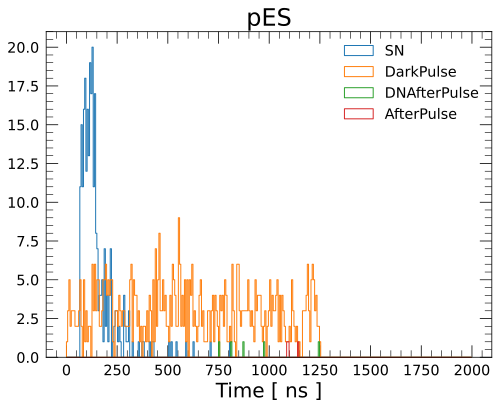

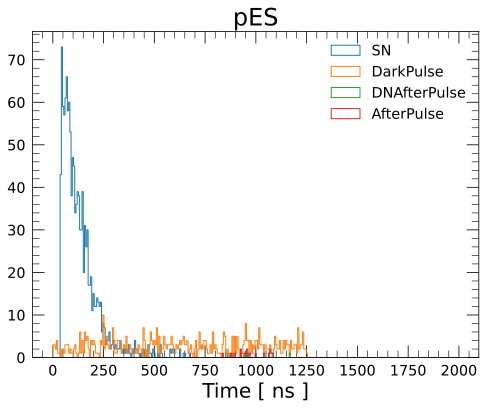

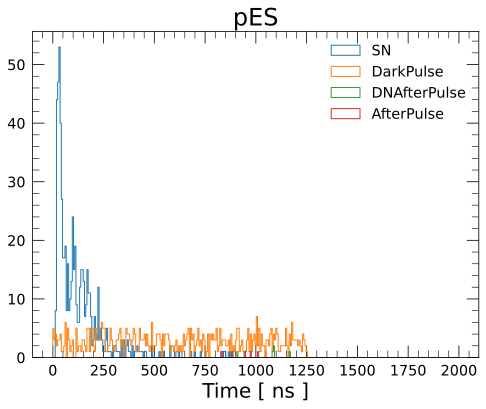

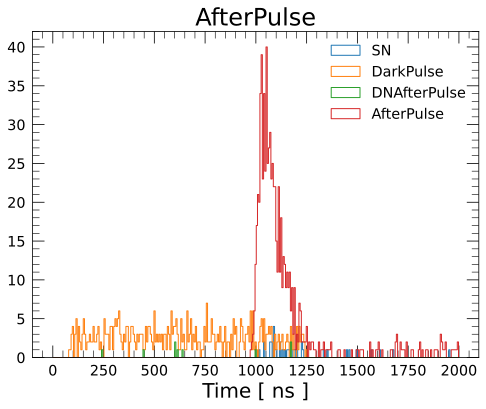

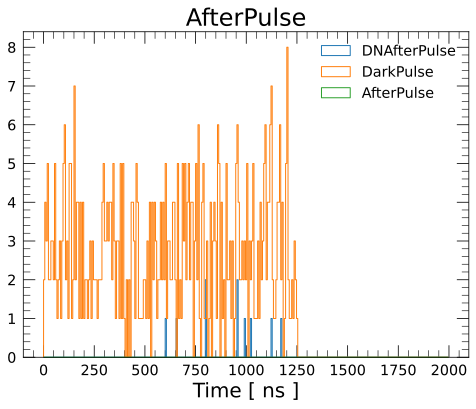

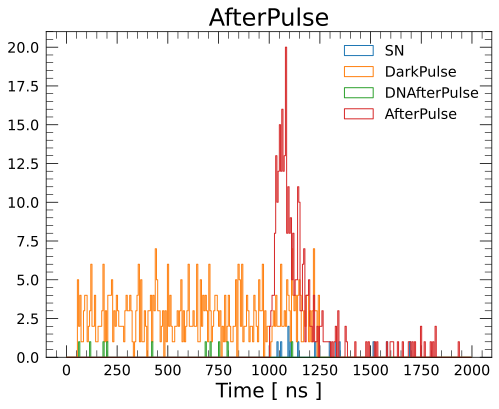

In [13]:
if use_TimeTruth:
    for tag in v_tags:
        for index, row in list( df_concat[df_concat["evtType"]==tag].iterrows() )[:3]:
            plt.figure()
            for pulseType in set(row["HitTypeTruth"]):
                v_time_with_tag = row["TimeTruth"][row["HitTypeTruth"]==pulseType]
                plt.hist(v_time_with_tag, bins=np.arange(0,2000,6), histtype="step", label=pulseType)
            plt.legend()
            plt.xlabel("Time [ ns ]")
            plt.title(tag)
